In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ifm3dpy as ifm3d

In [2]:
# Grab one time-correlated frame off the camera with all data
# (i.e., distance image, unit vectors,
#  on-board computed point cloud for ground truth comparisions, etc.)
cam = ifm3d.Camera()
fg = ifm3d.FrameGrabber(cam, 0xFFFF)
im = ifm3d.ImageBuffer()
assert(fg.wait_for_frame(im, 1000))

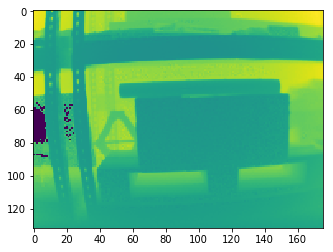

In [3]:
# Let's look at the distance image just to validate the data
# are there
plt.imshow(im.distance_image())

In [4]:
def compute_cartesian(im):
    #
    # Given an ifm3d ImageBuffer `im`
    #
    extr = im.extrinsics()
    tx = extr[0]
    ty = extr[1]
    tz = extr[2]

    uvec = im.unit_vectors()
    ex = uvec[:,:,0]
    ey = uvec[:,:,1]
    ez = uvec[:,:,2]

    rdis = im.distance_image()
    # cast to float
    rdis_f = rdis.astype(np.float32)
    if (rdis.dtype == np.float32):
        # if the distance values from the camera were float,
        # assume they were meters and so convert to mm
        # for comparisions
        rdis_f *= 1000.
    
    # Cartesian values in optical frame
    x_ = ex * rdis_f + tx
    y_ = ey * rdis_f + ty
    z_ = ez * rdis_f + tz
    
    # Account for bad pixels
    mask = rdis == 0
    x_[mask] = 0
    y_[mask] = 0
    z_[mask] = 0

    # convert to camera coord frame and also cast back to
    # int16 (the ground-truth data are int16 and mm)
    x = z_.astype(np.int16)
    y = -(x_.astype(np.int16))
    z = -(y_.astype(np.int16))
    
    return np.dstack((x, y, z))

In [5]:
# this is our off-board point cloud computation
cloud_computed = compute_cartesian(im)

# this is what was computed on the camera - I'm assuming O3D here,
# if using O3X, you may have to type cast from float to in and convert
# from meters to mm.
cloud_onboard = im.xyz_image()

# Let's look at the max deviation in each dimension (mm)
x_diff = np.abs(cloud_computed[:,:,0] - cloud_onboard[:,:,0])
y_diff = np.abs(cloud_computed[:,:,1] - cloud_onboard[:,:,1])
z_diff = np.abs(cloud_computed[:,:,2] - cloud_onboard[:,:,2])

(np.amax(x_diff), np.amax(y_diff), np.amax(z_diff)) # units are mm

(1, 1, 1)